In [3]:
import sys
# sys.path.append(r"Y:\Users\Yingyue\Gates_Lab_Suite-master")
sys.path.append(r"/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master")
from Core_Definition import *
from Auto_Algorithm import *
from Visualization import *
import os
from SPAM import *
import numpy as np
import xlsxwriter as xlsx
from scipy import optimize
import random
import math
from math import floor
import pickle
import uuid

In [4]:
import json, pickle
import qiskit
#transpiler reducinig qiskit circuit to QASM strings
from qiskit import transpile
# Use AerSimulator
from qiskit_aer import AerSimulator
from qiskit import IBMQ, QuantumCircuit, execute
from qiskit.providers.ibmq.managed import IBMQJobManager
from qiskit.extensions import UnitaryGate
from qiskit.quantum_info import Pauli, Clifford, Statevector,Operator
from qiskit.visualization import array_to_latex
from scipy.stats import sem, unitary_group
from scipy.linalg import sqrtm,expm
import qiskit.quantum_info as qi
from qiskit.quantum_info import Pauli
import pylatexenc

In [5]:
def state_init_bell_pairs(qc,n):
    for i in range (n):
        qc.Add_Gate(Quantum_Gate("HAD",i))
    for i in range (n):
        qc.Add_Gate(Quantum_Gate("CNOT",i,int(i+n)))

        
#should we set_mapping in this function? need to think about if it takes mapping into account   
def add_pauli_twirl(qc,n):
    pauliLayer = [random.choice(['I','X','Y','Z']) for j in range(n)]
    q_index=0
    for pauli in pauliLayer :
        if (pauli=="I"):
            qc.Add_Gate(Quantum_Gate("SKAX",2*n,angle=1))
        elif (pauli=="X"):
            qc.Add_Gate(Quantum_Gate("SKAX",q_index,angle=1))
        elif (pauli=="Y"):
            qc.Add_Gate(Quantum_Gate("SKAY",q_index,angle=1))
        elif (pauli=="Z"):
            qc.Add_Gate(Quantum_Gate("AZ",q_index,angle=1))
        q_index+=1
    return pauliLayer

def add_pauli_twirl_wSE(qc,n):
    pauliLayer = [random.choice(['I','X','Y','Z']) for j in range(n)]
    q_index=0
    for pauli in pauliLayer :
        if (pauli=="I"):
            qc.Add_Gate(Quantum_Gate("SKAX",2*n,angle=1))
        elif (pauli=="X"):
            qc.Add_Gate(Quantum_Gate("SKAX",q_index,angle=1))
        elif (pauli=="Y"):
            qc.Add_Gate(Quantum_Gate("SKAY",q_index,angle=1))
        elif (pauli=="Z"):
            qc.Add_Gate(Quantum_Gate("AZ",q_index,angle=1))
        
        if (q_index==(int(n/2)-1)):
            for i in range (n):
                qc.Add_Gate(Quantum_Gate("SKAX",n+i,angle=1))
        q_index+=1
    return pauliLayer
    
def add_clifford_layer(qc,n,clifford):
    if (clifford=="CNOT"):
        for i in range (floor(n/2)):
            qc.Add_Gate(Quantum_Gate("CNOT",2*i,2*i+1))
            
def bell_measurement(qc,n):
    for i in range (n-1,-1,-1):
        qc.Add_Gate(Quantum_Gate("SKAX",int(i+n),angle=1))
        qc.Add_Gate(Quantum_Gate("CNOT",i,int(i+n)))
    for i in range (n-1,-1,-1):
        qc.Add_Gate(Quantum_Gate("HAD",i))

def map_statepop_2_ibm_mapping(counts,n):
    counts_ibm_mapping=[0 for i in range (2**(2*n))]
    idx_ibm_mapping=[]
    counts_ibm_mapping_dic={}
    if len(str((2*n)))<2:
        f="00"+str(2*n)+"b"
    elif len(str((2*n)))<3:
        f="0"+str(2*n)+"b"
    else:
        raise ValueError("n is too big")
    for gates_idx in range (2**(2*n)):
        gates_idx_str=format(gates_idx,f)
        ibm_idx=0
        for i in range (2*n):
            ibm_idx+=2**(i)*int(gates_idx_str[i])
        ibm_idx_str=format(ibm_idx,f)
#         idx_ibm_mapping.append(ibm_idx_str)
        counts_ibm_mapping[ibm_idx]=counts[gates_idx]
        counts_ibm_mapping_dic[ibm_idx_str]=counts[gates_idx]
    return counts_ibm_mapping, counts_ibm_mapping_dic
        
        
#for qiskit
def prepare_bell_state_1q(circuit,index1,index2):
	circuit.h([index1])
	circuit.cx([index1],[index2])
        
def bell_measurement_1q(circuit,index1,index2): 
	# info qubit at index1
	circuit.cx([index1],[index2])
	circuit.h([index1])

def pauli_gate_1q(circuit,index,pauli=None): #For stabilizer simulator to work, cannot use Pauli class
	if pauli == 'I':
		circuit.id([index])
	elif pauli == 'Z':
		circuit.z([index])
	elif pauli == 'X':
		circuit.x([index])
	elif pauli == 'Y':
		circuit.y([index])
	else:
		assert 1==0

    
    
    

In [6]:
## Additional functions

def int_to_pauli(i,n):
    p = np.base_repr(i,base=4)
    p = '0'*(n-len(p)) + p
    p = p.replace('0','I').replace('1', 'X').replace('2', 'Y').replace('3', 'Z')
    return p

def commute(p,q):
    c = 1
    n = len(p)
    for i in range(n):
        if p[i] != 'I' and q[i] != 'I':
            if p[i] != q[i]:
                c *= -1
    return c

def fidelity_to_error(pauli_fidelity,n):
    N = 4**n
    pauli_error = {}
    for i in range(N):
        p = int_to_pauli(i,n)
        pauli_error[p] = 0
        for j in range(N):
            q = int_to_pauli(j,n)
            pauli_error[p] += pauli_fidelity[q] * commute(p,q) / N
    return pauli_error
    

In [8]:
Set_Mapping([1,3,4,5,2])
nqubit=2
# C=10
# results_d2=np.zeros((C,2**(2*nqubit)))
# results_d4=np.zeros((C,2**(2*nqubit)))
# results_d8=np.zeros((C,2**(2*nqubit)))

file=open(r"/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/circuits/0516/13452 0516 FT explicit CNOT R rotations auto/d=2.txt", 'r')
Lines= file.readlines()
c_R=[]
count = 0
for line in Lines:
    c_R.append(line)
    count += 1
print (count)
count=0

file=open(r"/Volumes/funkflower/Labs/Gates/AutoAlgorithms/EAB/0516/test SK1 and R/13452 R FT explicit SK1.txt", 'r')
Lines= file.readlines()
c_SK1=[]
count = 0
for line in Lines:
    c_SK1.append(line)
    count += 1
print (count)
count=0

# file=open(r"/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/circuits/23541 EAB XX C=10 0424  set2/d=2.txt", 'r')
# Lines= file.readlines()
# c_d2=[]
# count = 0
# for line in Lines:
#     c_d2.append(line)
#     count += 1
# print (count)
# count=0


20
10


In [11]:
filenames_R=[]
filenames_SK1=[]
# filenames_0426=[]

filenames=[]

paf_data_R="/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/0516 FTXX 13452/13452 explicit CNOT FT R/d=2 13452 FT R/"
L1=[]
filenames=[]
line_Idx="000"
line_num=""
p=0 #position indicator

#------------------------------------------read in raw data-------------------------------
for f in os.listdir(paf_data_R):
    if (f.find("Line")!=-1):
        n=f.find("_")
        line_Idx=f[n+6:n+9]
        for i in range(3):
            if line_Idx[i]=="0":
                p+=1
            else:
                line_num=line_Idx[p:3]
                p=0
                break
        L1.append(int(line_num))
        filenames.append(f)
    else:
        print (f) #print out non datafiles just for debugging 
        continue
for Idx in range (len(filenames)):
    for i in range (len(filenames)):
        if L1[i]==Idx+1:
            filenames_R.append(filenames[i])
            break
print (filenames_R)

paf_data_SK1="/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/0516 FTXX 13452/2023-05-16 test R SK1-Sk1/"
L1=[]
filenames=[]
line_Idx="000"
line_num=""
p=0 #position indicator

#------------------------------------------read in raw data-------------------------------
for f in os.listdir(paf_data_SK1):
    if (f.find("Line")!=-1):
        n=f.find("_")
        line_Idx=f[n+6:n+9]
        for i in range(3):
            if line_Idx[i]=="0":
                p+=1
            else:
                line_num=line_Idx[p:3]
                p=0
                break
        L1.append(int(line_num))
        filenames.append(f)
    else:
        print (f) #print out non datafiles just for debugging 
        continue
for Idx in range (len(filenames)):
    for i in range (len(filenames)):
        if L1[i]==Idx+1:
            filenames_SK1.append(filenames[i])
            break
print (filenames_SK1)



['2023-05-16-195131_Line_001.txt', '2023-05-16-195213_Line_002.txt', '2023-05-16-195256_Line_003.txt', '2023-05-16-195337_Line_004.txt', '2023-05-16-195537_Line_005.txt', '2023-05-16-195621_Line_006.txt', '2023-05-16-195703_Line_007.txt', '2023-05-16-195744_Line_008.txt', '2023-05-16-195943_Line_009.txt', '2023-05-16-200028_Line_010.txt', '2023-05-16-200111_Line_011.txt', '2023-05-16-200152_Line_012.txt', '2023-05-16-200351_Line_013.txt', '2023-05-16-200434_Line_014.txt', '2023-05-16-200516_Line_015.txt', '2023-05-16-200559_Line_016.txt', '2023-05-16-200758_Line_017.txt', '2023-05-16-200840_Line_018.txt', '2023-05-16-200923_Line_019.txt', '2023-05-16-201005_Line_020.txt']
['2023-05-16-235544_Line_001.txt', '2023-05-16-235632_Line_002.txt', '2023-05-16-235719_Line_003.txt', '2023-05-16-235806_Line_004.txt', '2023-05-17-000012_Line_005.txt']


In [13]:
a_R=Quantum_State(5)
a_SK1=Quantum_State(5)
# a_0426=Quantum_State(5)
# a_s=Quantum_State(5)
b_c_R=Quantum_Circuit(5,"qc")
b_c_SK1=Quantum_Circuit(5,"qc")

# spam1=SPAM_Operator(5)
# spam1.Import("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/0424/SPAM1/SPAM1.csv")

# spam2=SPAM_Operator(5)
# spam2.Import("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/0424/SPAM1/SPAM1.csv")


2023-05-16-195131_Line_001.txt
2023-05-16-235544_Line_001.txt
HAD1:HAD3:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:RX+11:RX+31:FTXA130.2500+:RX+11:RX+31:FTXA130.2500+:RY+11:RX+31:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:HAD1:HAD3

HAD1:HAD3:SK1Y+12:FTXA140.2500+:SK1Y-12:SK1X-42:AZ1-0.5000:SK1Y+32:FTXA350.2500+:SK1Y-32:SK1X-52:AZ3-0.5000:SK1X+11:SK1X+31:FTXA130.2500+:SK1X+11:SK1X+31:FTXA130.2500+:SK1Y+11:SK1X+31:SK1Y+12:FTXA140.2500+:SK1Y-12:SK1X-42:AZ1-0.5000:SK1Y+32:FTXA350.2500+:SK1Y-32:SK1X-52:AZ3-0.5000:HAD1:HAD3



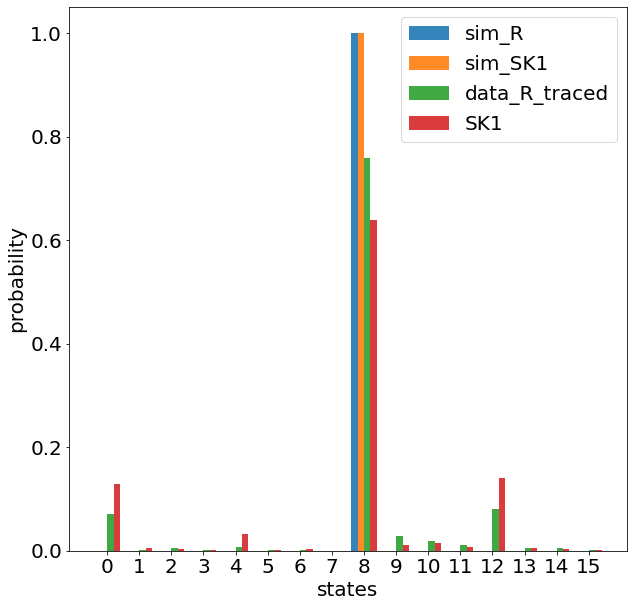

2023-05-16-195213_Line_002.txt
2023-05-16-235632_Line_002.txt
HAD1:HAD3:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:AZ1+1.0000:RY+31:FTXA130.2500+:RX+11:RX+31:FTXA130.2500+:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:HAD1:HAD3

HAD1:HAD3:SK1Y+12:FTXA140.2500+:SK1Y-12:SK1X-42:AZ1-0.5000:SK1Y+32:FTXA350.2500+:SK1Y-32:SK1X-52:AZ3-0.5000:AZ1+1.0000:SK1Y+31:FTXA130.2500+:SK1X+11:SK1X+31:FTXA130.2500+:SK1Y+12:FTXA140.2500+:SK1Y-12:SK1X-42:AZ1-0.5000:SK1Y+32:FTXA350.2500+:SK1Y-32:SK1X-52:AZ3-0.5000:HAD1:HAD3



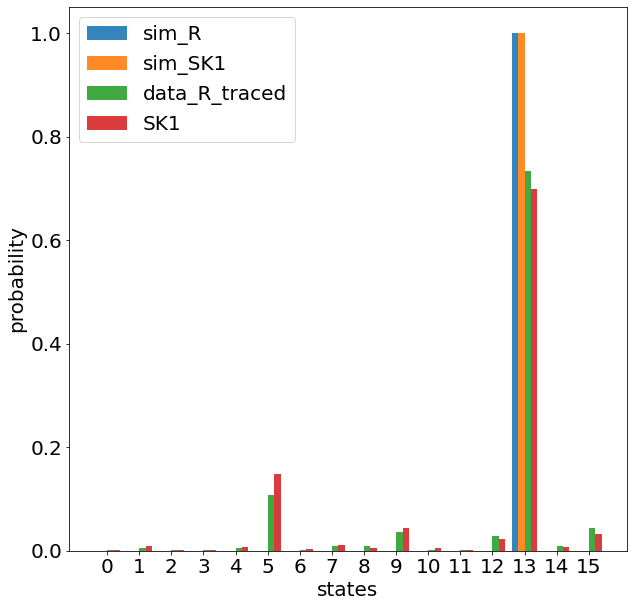

2023-05-16-195256_Line_003.txt
2023-05-16-235719_Line_003.txt
HAD1:HAD3:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:FTXA130.2500+:AZ3+1.0000:FTXA130.2500+:AZ1+1.0000:RY+31:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:HAD1:HAD3

HAD1:HAD3:SK1Y+12:FTXA140.2500+:SK1Y-12:SK1X-42:AZ1-0.5000:SK1Y+32:FTXA350.2500+:SK1Y-32:SK1X-52:AZ3-0.5000:FTXA130.2500+:AZ3+1.0000:FTXA130.2500+:AZ1+1.0000:SK1Y+31:SK1Y+12:FTXA140.2500+:SK1Y-12:SK1X-42:AZ1-0.5000:SK1Y+32:FTXA350.2500+:SK1Y-32:SK1X-52:AZ3-0.5000:HAD1:HAD3



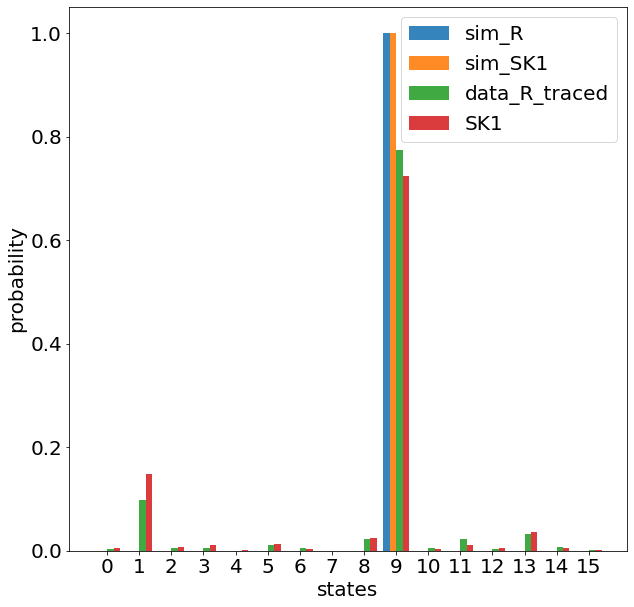

2023-05-16-195337_Line_004.txt
2023-05-16-235806_Line_004.txt
HAD1:HAD3:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:AZ1+1.0000:AZ3+1.0000:FTXA130.2500+:RY+31:FTXA130.2500+:RX+31:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:HAD1:HAD3

HAD1:HAD3:SK1Y+12:FTXA140.2500+:SK1Y-12:SK1X-42:AZ1-0.5000:SK1Y+32:FTXA350.2500+:SK1Y-32:SK1X-52:AZ3-0.5000:AZ1+1.0000:AZ3+1.0000:FTXA130.2500+:SK1Y+31:FTXA130.2500+:SK1X+31:SK1Y+12:FTXA140.2500+:SK1Y-12:SK1X-42:AZ1-0.5000:SK1Y+32:FTXA350.2500+:SK1Y-32:SK1X-52:AZ3-0.5000:HAD1:HAD3



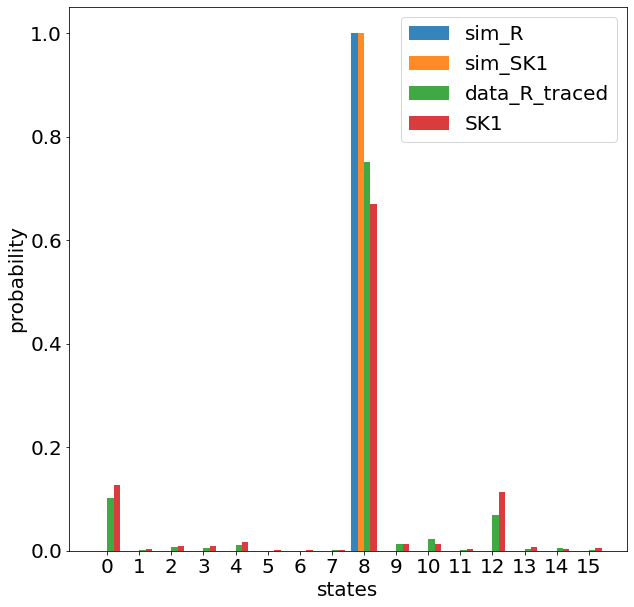

2023-05-16-195537_Line_005.txt
2023-05-17-000012_Line_005.txt
HAD1:HAD3:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:RX+11:RX+31:FTXA130.2500+:RX+11:RY+31:FTXA130.2500+:RX+11:RY+12:FTXA140.2500+:RY-12:RX-42:AZ1-0.5000:RY+32:FTXA350.2500+:RY-32:RX-52:AZ3-0.5000:HAD1:HAD3

HAD1:HAD3:SK1Y+12:FTXA140.2500+:SK1Y-12:SK1X-42:AZ1-0.5000:SK1Y+32:FTXA350.2500+:SK1Y-32:SK1X-52:AZ3-0.5000:SK1X+11:SK1X+31:FTXA130.2500+:SK1X+11:SK1Y+31:FTXA130.2500+:SK1X+11:SK1Y+12:FTXA140.2500+:SK1Y-12:SK1X-42:AZ1-0.5000:SK1Y+32:FTXA350.2500+:SK1Y-32:SK1X-52:AZ3-0.5000:HAD1:HAD3



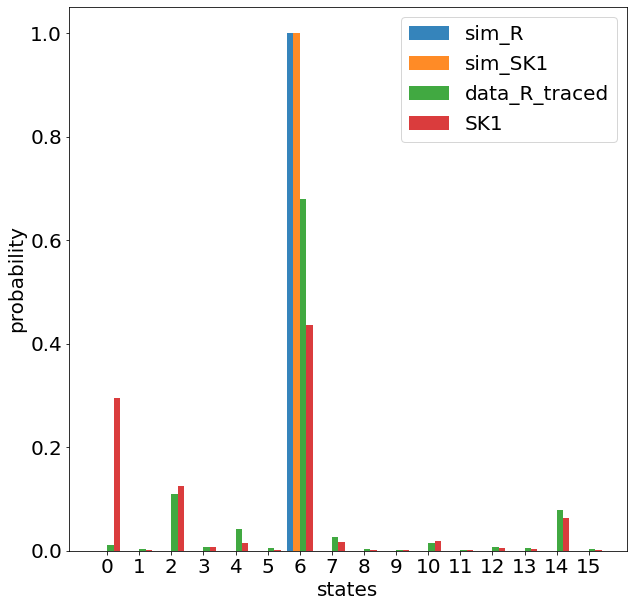

2023-05-16-195621_Line_006.txt


IndexError: list index out of range

In [15]:
filenames_data=[]
counts_d2=[]
counts_d2_spam=[]
shots=4000
counts=[]
counts_spam=[]

filenames_data_R=filenames_R.copy()
filenames_data_SK1=filenames_SK1.copy()
paf_data_R=paf_data_R
paf_data_SK1=paf_data_SK1

# circuit_R=c_R
# print (len(filenames_data))
for i in range (len(filenames_data_R)):
    print (filenames_data_R[i])
    print (filenames_data_SK1[i])
    a_R.Import(paf_data_R+filenames_data_R[i],keep_file=True)
    data_R_traced=Trace_Out(a_R,[0,1,2,3])

    a_SK1.Import(paf_data_SK1+filenames_data_SK1[i],keep_file=True)
    data_SK1_traced=Trace_Out(a_SK1,[0,1,2,3])
    
#     a_0426.Import(paf_data_0426+filenames_0426[i],keep_file=True)
#     data_0426_traced=Trace_Out(a_0426,[0,1,2,3])
#     counts=[round(shots*x) for x in  data_traced.population]
#     print ("counts:", counts)
#     counts_ibm_mapping, counts_ibm_mapping_dic=map_statepop_2_ibm_mapping(counts,nqubit)
#     print ("counts_ibm_mapping_dic:",counts_ibm_mapping_dic)
#     counts_d2.append(counts_ibm_mapping_dic)
    
#     a_s=spam1.Correct_SPAM(a)
#     data_traced_spam=Trace_Out(a_s,[0,1,2,3])
#     counts_spam=[round(shots*x) for x in  data_traced_spam.population]
#     counts_ibm_mapping_spam, counts_ibm_mapping_dic_spam=map_statepop_2_ibm_mapping(counts_spam,nqubit)
#     counts_d2_spam.append(counts_ibm_mapping_dic_spam)

    b_c_R.Interpret_GatesLab_Sequence(c_R[i])
    b_c_SK1.Interpret_GatesLab_Sequence(c_SK1[i])
    print (c_R[i])
    print (c_SK1[i])
    b_R=b_c_R.Simulate()
    b_SK1=b_c_SK1.Simulate()
    sim_R_traced=Trace_Out(b_R,[0,1,2,3])
    sim_SK1_traced=Trace_Out(b_SK1,[0,1,2,3])
#     Display_States_Population(states=[b,a],label=["simulation","d=2"])
    Display_States_Population(states=[sim_R_traced,sim_SK1_traced,data_R_traced,data_SK1_traced],label=["sim_R","sim_SK1","data_R_traced","SK1"])
# #         

In [13]:
# print (counts_d2[0])
# print (counts_d2_spam[0])

spam results